**Identify and Classify Toxic online comments**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install nltk

In [ ]:
import matplotlib.pyplot as plt
import nltk
import numpy as np
import re 
import pandas as pd
import string
import seaborn as sns

from nltk.corpus import stopwords
from nltk.stem.lancaster import LancasterStemmer


# Import packages that help us to create document-term matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [ ]:
nltk.download('all')

In [ ]:
set(stopwords.words('english'))

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/A-14 Miniproject/train.csv')
data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


In [ ]:
data['comment_text'][0]

"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"

In [ ]:
data['comment_text'][1]

"D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)"

In [ ]:
data['comment_text'][2]

"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info."

In [ ]:
data.severe_toxic.value_counts(normalize=True)

0    0.990004
1    0.009996
Name: severe_toxic, dtype: float64

In [ ]:
data.toxic.value_counts(normalize=True)

0    0.904156
1    0.095844
Name: toxic, dtype: float64

In [ ]:
data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [ ]:
data_count=data.iloc[:,2:].sum()

In [ ]:
data_count

toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


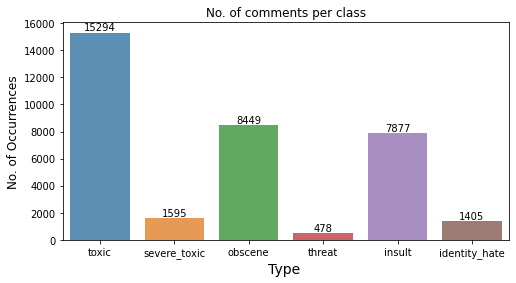

In [ ]:
plt.figure(figsize=(8,4))

# Plot a bar chart using the index (category values) and the count of each category. alpha = 0.8 to make the bars more translucent
ax = sns.barplot(data_count.index, data_count.values, alpha=0.8)

plt.title("No. of comments per class")
plt.ylabel('No. of Occurrences', fontsize=12)
plt.xlabel('Type ', fontsize=14)
rects = ax.patches
labels = data_count.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

In [ ]:
num_rows=len(data)
print(num_rows)

159571


In [ ]:
import string
alphanumeric = lambda x: re.sub('\w*\d\w*',' ',x)

In [ ]:
# '[%s]' % re.escape(string.punctuation),' ' - replace punctuation with white space
# .lower() - convert all strings to lowercase 
punc_lower = lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x.lower())

# Remove all '\n' in the string and replace it with a space
remove_n = lambda x: re.sub("\n", " ", x)

# Remove all non-ascii characters 
remove_non_ascii = lambda x: re.sub(r'[^\x00-\x7f]',r' ', x)

# Apply all the lambda functions wrote previously through .map on the comments column
data['comment_text'] = data['comment_text'].map(alphanumeric).map(punc_lower).map(remove_n).map(remove_non_ascii)

data['comment_text'][0]

'explanation why the edits made under my username hardcore metallica fan were reverted  they weren t vandalisms  just closure on some gas after i voted at new york dolls fac  and please don t remove the template from the talk page since i m retired now        '

In [ ]:
data_tox=data.loc[:,['id','comment_text','toxic']]

In [ ]:
data_obs = data.loc[:,['id','comment_text','obscene']]
data_thr = data.loc[:,['id','comment_text','threat']]
data_ins = data.loc[:,['id','comment_text','insult']]
data_ide = data.loc[:,['id','comment_text','identity_hate']]
data_sev = data.loc[:,['id','comment_text','severe_toxic']]

In [ ]:
import wordcloud
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from nltk.corpus import stopwords

In [ ]:
def wordcloud(df, label):
    
    # Print only rows where the toxic category label value is 1 (ie. the comment is toxic)
    subset=df[df[label]==1]
    text=subset.comment_text.values
    wc= WordCloud(background_color="black",max_words=4000)

    wc.generate(" ".join(text))

    plt.figure(figsize=(20,20))
    plt.subplot(221)
    plt.axis("off")
    plt.title("Words frequented in {}".format(label), fontsize=20)
    plt.imshow(wc.recolor(colormap= 'gist_earth' , random_state=244), alpha=0.98)

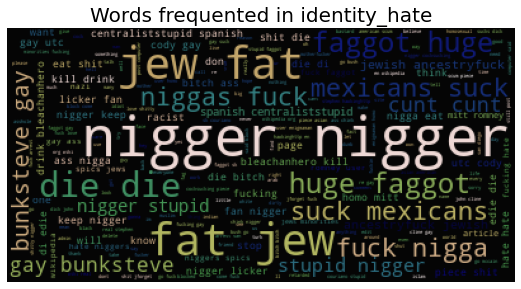

In [ ]:
wordcloud(data_ide,'identity_hate')

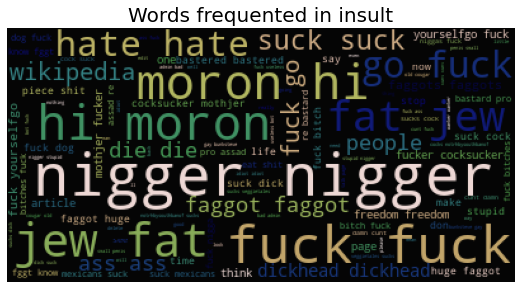

In [ ]:
wordcloud(data_ins, 'insult')

In [ ]:
data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,explanation why the edits made under my userna...,0,0,0,0,0,0
1,000103f0d9cfb60f,d aww he matches this background colour i m s...,0,0,0,0,0,0
2,000113f07ec002fd,hey man i m really not trying to edit war it...,0,0,0,0,0,0
3,0001b41b1c6bb37e,more i can t make any real suggestions on im...,0,0,0,0,0,0
4,0001d958c54c6e35,you sir are my hero any chance you remember...,0,0,0,0,0,0


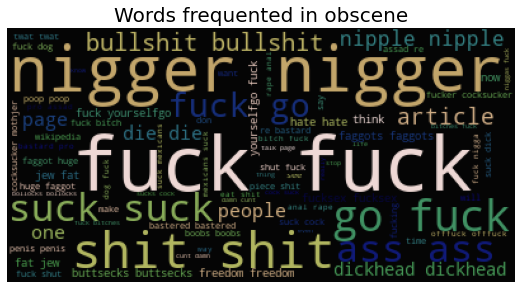

In [ ]:
wordcloud(data_obs, 'obscene')

In [ ]:
data_tox.head()

,id,comment_text,toxic
0,0000997932d777bf,explanation why the edits made under my userna...,0
1,000103f0d9cfb60f,d aww he matches this background colour i m s...,0
2,000113f07ec002fd,hey man i m really not trying to edit war it...,0
3,0001b41b1c6bb37e,more i can t make any real suggestions on im...,0
4,0001d958c54c6e35,you sir are my hero any chance you remember...,0


In [ ]:
data_tox_1 = data_tox[data_tox['toxic'] == 1].iloc[0:5000,:]
data_tox_1.shape

(5000, 3)

In [ ]:

data_tox_0 = data_tox[data_tox['toxic'] == 0].iloc[0:5000,:]

In [ ]:
data_tox_0.shape

(5000, 3)

In [ ]:
data_tox_done = pd.concat([data_tox_1, data_tox_0], axis=0)
data_tox_done.shape

(10000, 3)

In [ ]:
data_sev[data_sev['severe_toxic'] == 1].count()


id              1595
comment_text    1595
severe_toxic    1595
dtype: int64

In [ ]:
data_sev_1 = data_sev[data_sev['severe_toxic'] == 1].iloc[0:1595,:]
data_sev_0 = data_sev[data_sev['severe_toxic'] == 0].iloc[0:1595,:]
data_sev_done = pd.concat([data_sev_1, data_sev_0], axis=0)
data_sev_done.shape

(3190, 3)

In [ ]:
data_obs[data_obs['obscene'] == 1].count()

id              8449
comment_text    8449
obscene         8449
dtype: int64

In [ ]:
data_obs_1 = data_obs[data_obs['obscene'] == 1].iloc[0:5000,:]
data_obs_0 = data_obs[data_obs['obscene'] == 0].iloc[0:5000,:]
data_obs_done = pd.concat([data_obs_1, data_obs_0], axis=0)
data_obs_done.shape

(10000, 3)

In [ ]:
data_thr[data_thr['threat'] == 1].count()

id              478
comment_text    478
threat          478
dtype: int64

In [ ]:
data_thr_1 = data_thr[data_thr['threat'] == 1].iloc[0:478,:]
data_thr_0 = data_thr[data_thr['threat'] == 0].iloc[0:1912,:]  
data_thr_done = pd.concat([data_thr_1, data_thr_0], axis=0)
data_thr_done.shape

(2390, 3)

In [ ]:
data_ins[data_ins['insult'] == 1].count()

id              7877
comment_text    7877
insult          7877
dtype: int64

In [ ]:
data_ins_1 = data_ins[data_ins['insult'] == 1].iloc[0:5000,:]
data_ins_0 = data_ins[data_ins['insult'] == 0].iloc[0:5000,:]
data_ins_done = pd.concat([data_ins_1, data_ins_0], axis=0)
data_ins_done.shape

(10000, 3)

In [ ]:
data_ide[data_ide['identity_hate'] == 1].count()

id               1405
comment_text     1405
identity_hate    1405
dtype: int64

In [ ]:
data_ide_1 = data_ide[data_ide['identity_hate'] == 1].iloc[0:1405,:] # 20%
data_ide_0 = data_ide[data_ide['identity_hate'] == 0].iloc[0:5620,:] # 80%
data_ide_done = pd.concat([data_ide_1, data_ide_0], axis=0)
data_ide_done.shape

(7025, 3)

In [ ]:
from sklearn import preprocessing
from sklearn.feature_selection import SelectFromModel

In [ ]:
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import f1_score, precision_score, recall_score, precision_recall_curve, fbeta_score, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [ ]:
def cv_train_test(df_done,label,vectorizer,ngram):
  X=df_done.comment_text
  y=df_done[label]
  X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.3,random_state=42)
  cv1=vectorizer(ngram_range=(ngram),stop_words='english')
  X_train_cv1=cv1.fit_transform(X_train)
  X_test_cv1= cv1.transform(X_test)
  lr= LogisticRegression()
  lr.fit(X_train_cv1,y_train)
  print('LR done')
  randomforest = RandomForestClassifier(n_estimators=100, random_state=42)
  randomforest.fit(X_train_cv1, y_train)
  print('rdf done')
  f1_score_data = {'F1 Score':[f1_score(lr.predict(X_test_cv1), y_test),f1_score(randomforest.predict(X_test_cv1), y_test)]} 
                          
  # Create DataFrame with the model names as column labels
  df_f1 = pd.DataFrame(f1_score_data, index=['Log Regression', 'Random Forest'])  

  return df_f1

In [ ]:
import time

t0 = time.time()

df_tox_cv = cv_train_test(data_tox_done, 'toxic', TfidfVectorizer, (1,1))
df_tox_cv.rename(columns={'F1 Score': 'F1 Score(toxic)'}, inplace=True)

t1 = time.time()

total = 'Time taken: {} seconds'.format(t1-t0)
print(total)

df_tox_cv

LR done
rdf done
Time taken: 9.963246583938599 seconds


,F1 Score(toxic)
Log Regression,0.861234
Random Forest,0.838055


In [ ]:

t0 = time.time()

df_sev_cv = cv_train_test(data_sev_done, 'severe_toxic', TfidfVectorizer, (1,1))
df_sev_cv.rename(columns={'F1 Score': 'F1 Score(severe_toxic)'}, inplace=True)

t1 = time.time()

total = 'Time taken: {} seconds'.format(t1-t0)
print(total)
df_sev_cv

LR done
rdf done
Time taken: 1.8606617450714111 seconds


,F1 Score(severe_toxic)
Log Regression,0.927879
Random Forest,0.934874


In [ ]:

t0 = time.time()

df_obs_cv = cv_train_test(data_obs_done, 'obscene', TfidfVectorizer, (1,1))
df_obs_cv.rename(columns={'F1 Score': 'F1 Score(obscene)'}, inplace=True)

t1 = time.time()

total = 'Time taken: {} seconds'.format(t1-t0)
print(total)

df_obs_cv

LR done
rdf done
Time taken: 8.982487678527832 seconds


,F1 Score(obscene)
Log Regression,0.908655
Random Forest,0.909091


In [ ]:

t0 = time.time()

df_thr_cv = cv_train_test(data_thr_done, 'threat', TfidfVectorizer, (1,1))
df_thr_cv.rename(columns={'F1 Score': 'F1 Score(threat)'}, inplace=True)

t1 = time.time()

total = 'Time taken: {} seconds'.format(t1-t0)
print(total)

df_thr_cv

LR done
rdf done
Time taken: 1.2879457473754883 seconds


,F1 Score(threat)
Log Regression,0.628821
Random Forest,0.795539


In [ ]:

t0 = time.time()

df_ins_cv = cv_train_test(data_ins_done, 'insult', TfidfVectorizer, (1,1))
df_ins_cv.rename(columns={'F1 Score': 'F1 Score(insult)'}, inplace=True)

t1 = time.time()

total = 'Time taken: {} seconds'.format(t1-t0)
print(total)

df_ins_cv

LR done
rdf done
Time taken: 9.463340044021606 seconds


,F1 Score(insult)
Log Regression,0.896599
Random Forest,0.883993


In [ ]:
t0 = time.time()

df_ide_cv = cv_train_test(data_ide_done, 'identity_hate', TfidfVectorizer, (1,1))
df_ide_cv.rename(columns={'F1 Score': 'F1 Score(identity_hate)'}, inplace=True)

t1 = time.time()

total = 'Time taken: {} seconds'.format(t1-t0)
print(total)

df_ide_cv

LR done
rdf done
Time taken: 5.2337846755981445 seconds


,F1 Score(identity_hate)
Log Regression,0.699029
Random Forest,0.768448


In [ ]:
f1_all = pd.concat([df_tox_cv, df_sev_cv, df_obs_cv, df_ins_cv, df_thr_cv, df_ide_cv], axis=1)
f1_all

,F1 Score(toxic),F1 Score(severe_toxic),F1 Score(obscene),F1 Score(insult),F1 Score(threat),F1 Score(identity_hate)
Log Regression,0.861234,0.927879,0.908655,0.896599,0.628821,0.699029
Random Forest,0.838055,0.934874,0.909091,0.883993,0.795539,0.768448


In [ ]:
data_tox_done.shape

(10000, 3)

In [ ]:
X = data_tox_done.comment_text
y = data_tox_done['toxic']
X1 = data_obs_done.comment_text
y1 = data_obs_done['obscene']
X2 = data_sev_done.comment_text
y2 = data_sev_done['severe_toxic']
X3 = data_ide_done.comment_text
y3 = data_ide_done['identity_hate']
X4 = data_ins_done.comment_text
y4 = data_ins_done['insult']
X5 = data_thr_done.comment_text
y5 = data_thr_done['threat']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.3, random_state=42)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.3, random_state=42)
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.3, random_state=42)
X4_train, X4_test, y4_train, y4_test = train_test_split(X4, y4, test_size=0.3, random_state=42)
X5_train, X5_test, y5_train, y5_test = train_test_split(X5, y5, test_size=0.3, random_state=42)

# Initiate a Tfidf vectorizer
tfv = TfidfVectorizer(ngram_range=(1,1), stop_words='english')
tfvit = TfidfVectorizer(ngram_range=(1,1), stop_words='english')
tfvsev = TfidfVectorizer(ngram_range=(1,1), stop_words='english')
tfvide = TfidfVectorizer(ngram_range=(1,1), stop_words='english')
tfvins = TfidfVectorizer(ngram_range=(1,1), stop_words='english')
tfvthr = TfidfVectorizer(ngram_range=(1,1), stop_words='english')

#Toxic
X_train_fit = tfv.fit_transform(X_train)  # Convert the X data into a document term matrix dataframe
X_test_fit = tfv.transform(X_test)  # Converts the X_test comments into Vectorized format+
randomforest = RandomForestClassifier(n_estimators=100, random_state=42)
randomforest.fit(X_train_fit, y_train)
randomforest.predict(X_test_fit)

#obscene
X1_train_fit = tfvit.fit_transform(X1_train)  # Convert the X data into a document term matrix dataframe
X1_test_fit = tfvit.transform(X1_test)  # Converts the X_test comments into Vectorized format+
randomforest1 = RandomForestClassifier(n_estimators=100, random_state=42)
randomforest1.fit(X1_train_fit, y1_train)
randomforest1.predict(X1_test_fit)

#severe_toxic
X2_train_fit = tfvsev.fit_transform(X2_train)  # Convert the X data into a document term matrix dataframe
X2_test_fit = tfvsev.transform(X2_test)  # Converts the X_test comments into Vectorized format+
randomforestsev = RandomForestClassifier(n_estimators=100, random_state=42)
randomforestsev.fit(X2_train_fit, y2_train)
randomforestsev.predict(X2_test_fit)

#identity hate
X3_train_fit = tfvide.fit_transform(X3_train)  # Convert the X data into a document term matrix dataframe
X3_test_fit = tfvide.transform(X3_test)  # Converts the X_test comments into Vectorized format+
randomforestide = RandomForestClassifier(n_estimators=100, random_state=42)
randomforestide.fit(X3_train_fit, y3_train)
randomforestide.predict(X3_test_fit)

#Insult
X4_train_fit = tfvins.fit_transform(X4_train)  # Convert the X data into a document term matrix dataframe
X4_test_fit = tfvins.transform(X4_test)  # Converts the X_test comments into Vectorized format+
randomforestins = RandomForestClassifier(n_estimators=100, random_state=42)
randomforestins.fit(X4_train_fit, y4_train)
randomforestins.predict(X4_test_fit)

#threat
X5_train_fit = tfvthr.fit_transform(X5_train)  # Convert the X data into a document term matrix dataframe
X5_test_fit = tfvthr.transform(X5_test)  # Converts the X_test comments into Vectorized format+
randomforestthr = RandomForestClassifier(n_estimators=100, random_state=42)
randomforestthr.fit(X5_train_fit, y5_train)
randomforestthr.predict(X5_test_fit)

In [ ]:
t=input("Enter the comment ")
txt=[t]
comment1_vect = tfv.transform(txt)
print("Toxic:",[randomforest.predict_proba(comment1_vect)[:,1]])
comment1_vect1 = tfvit.transform(txt)
print("Obscene:",[randomforest1.predict_proba(comment1_vect1)[:,1]])
comment1_vect11 = tfvsev.transform(txt)
print("severe_toxic:",[randomforestsev.predict_proba(comment1_vect11)[:,1]])
comment1_vect111 = tfvide.transform(txt)
print("Identity_hate:",[randomforestide.predict_proba(comment1_vect111)[:,1]])
comment1_vect101 = tfvins.transform(txt)
print("Insult:",[randomforestins.predict_proba(comment1_vect101)[:,1]])
comment1_vect1010 = tfvthr.transform(txt)
print("Threat:",[randomforestthr.predict_proba(comment1_vect1010)[:,1]])

Enter the comment go die motherfucker
Toxic: [array([0.95827656])]
Obscene: [array([0.96161905])]
severe_toxic: [array([1.])]
Identity_hate: [array([0.38881854])]
Insult: [array([0.97428571])]
Threat: [array([0.92])]
